## Semantic segmentation on deep drive
### Task No. 1
> Group No 3

>>**1. Ammar Ahmad (19100176)**

>>**2. Tooba Mukhtar (19100210)**

In [1]:
# Description of importing the required libraries
# Numpy : used to manage data structutes and images. helpful in preprocessing
# Keras: used to implement the network 
# Pandas: used to read label information
# matlplotlib: used to plot data

In [8]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.engine.topology import Input
from keras.layers.core import Dense, Dropout, Activation,Reshape
from keras.layers import Conv1D, Conv2D, Flatten, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.utils import plot_model
from keras.optimizers import Adam,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [9]:
batch = 1
epochs = 1;
num_classes = 41;
input_Shape = (150,150)

### Description of batch generator 
    Keras provides an image data generator which has been used to load images from a directory. The batch generator loads images in memory in parallel with model.fit. A wrapper has been used above this batch generator to implement soe other functionalities. 
#### Task 1a

In [12]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        'data_deep_drive/Training',
        target_size=input_Shape,
        batch_size=batch,
        color_mode = 'rgb',
        class_mode=None)
train_generator_labels = train_datagen.flow_from_directory(
        'data_deep_drive_labels/Training',
        target_size=input_Shape,
        batch_size=batch,
        color_mode = 'rgb',
        class_mode=None)


test_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_generator = train_datagen.flow_from_directory(
        'data_deep_drive/Testing',
        target_size=input_Shape,
        batch_size=batch,
        color_mode = 'rgb',
        class_mode=None)
test_generator_labels = train_datagen.flow_from_directory(
        'data_deep_drive_labels/Testing',
        target_size=input_Shape,
        batch_size=batch,
        color_mode = 'rgb',
        class_mode=None)

train_gen = zip(train_generator,train_generator_labels)
test_gen = zip(test_generator,test_generator_labels)

Found 800 images belonging to 1 classes.
Found 800 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.


## Description of To_Categorical Conversion
    We have image segmentation maps which are of size (rows,cols,3) and we want to convert them to (rows,cols,nb_classes) so that each pixel belongs to a class. RGB value of every pixel is looked up and compared ot RGB value of every class and if it matches then it is set to 1 otherwise 0 so that the labels are in the form of a mask.
### Task 1b

## Load Class Names and values

In [25]:
classes = pd.read_csv('label_colors.csv',sep='\t',header=None)
classes['class'] = classes.index.values.astype(int)
classes.columns = ['rgb','name','class']

In [14]:
def image_map(im,classes) :
    t = np.zeros((150,150,41),dtype = 'float32')
    for n in range(num_classes) :
        temp_img = np.zeros((150,150),dtype = 'float32')
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
            
                temp = str(im[i,j,0]) + ' ' + str(im[i,j,1]) + ' ' + str(im[i,j,2])
                if (temp == classes['rgb'][n]) :
                    temp_img[i,j] = 1
                else:
                    temp_img[i,j] = 0
        
        t[:,:,n] = temp_img

    return t

In [15]:
class my_train_gen(object):
    def __init__(self, Xs):
        self.Xs = Xs

    def __iter__(self):
        return self

    # Python 3 compatibility
    def __next__(self):
        return self.next()

    def next(self):
        try:
            batch_x,batch_y = next(self.Xs)
            t = np.zeros((len(batch_y),batch_y[0].shape[0],batch_y[0].shape[1],41),dtype = 'float32')
            for index,img in enumerate(batch_y):
                seg_map = image_map(img,classes)
                t[index,:,:,:] = seg_map
            return (batch_x, t)
        except Exception:
            raise StopIteration()

### Despription: Run Model
#### Task 1c
> Simplified Version of Segnet

> Description: Has 4 encoding and 4 corresponding decoding layers and a softmax layer at the end.


In [16]:
model = Sequential()
model.add(Conv2D(32,(3,3),padding = 'same',input_shape=(input_Shape[0],input_Shape[1],3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2),padding = 'same'))
model.add(Conv2D(128,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(64,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(num_classes,(3,3),padding = 'valid'))
model.add(BatchNormalization())
model.add(Activation('softmax'))

In [17]:
model.compile(optimizer = 'adadelta',loss = 'categorical_crossentropy')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 75, 75, 64)        0         
__________

In [21]:
auto_encoder_train = model.fit_generator(my_train_gen(train_gen), steps_per_epoch=10, epochs=epochs,validation_data = my_train_gen(test_gen),validation_steps = 10)

Epoch 1/1
10/10 [==============================] - 437s 44s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00


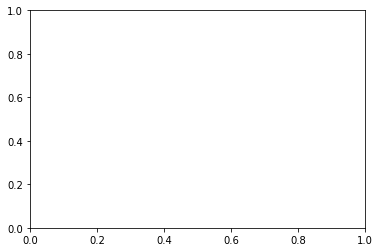

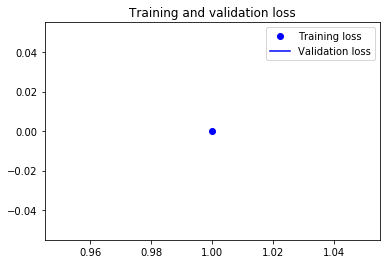

In [23]:
loss = auto_encoder_train.history['loss']
val_loss = auto_encoder_train.history['val_loss']
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Resulting Images (Masks)



In [ ]:
# Evaluate your model by predicting output segmentation maps with fine-tuned model
# Show results
# Report Accuracy

### Report Accuracy

# Summary of the paper

SEGNET

Main focus on how it up samples low resolution feature maps.
Non linear upsampling
Designed for road scene understanding application. 
Corresponding decoder for every encoder - Does up sampling based on the indices received from encoding max pooling layers. This approach is useful because “it improves boundary delineation” and “it reduces the number of parameters enabling end to end training”.

VGG16 vs SEGNET :
Both use the same approach (upsampling based on indices) for decoding but the main difference is in the decoding part. VGG16 has fully connected layers which increases the number of parameters to be learned. SEGNET disregards the fully connected layers at the deepest encoding output.This reduces the number of parameters. As a result the Segnet encoder network is significantly smaller and easier to train than many other recent architectures.
Segnet uses the SGD optimizer.

Architecture: 
13 encoding layers (similar to VGG16) and 13 decoding layers

Each encoder works as: 
Convolution with trainable filters
Batch normalization
ReLu
Max Pooling on 2x2 window and stride 2
Subsampling by a factor of 2
Store the indices of max pooling

Each decoder works as:
Up samples using the memorized indices
Convolution with trainable filters
Batch normalization


The final decoder output is fed to a multiclass softmax classifier to produce class probabilities for each pixel independently.
The high dimensional feature representation at the output of the final decoder is fed to a trainable softmax classifier. This soft-max classifies each pixel independently. The output of the softmax classifier is a K channel image of probabilities where K is the number of classes. The predicted segmentation corresponds to the class with maximum probability at each pixel.
